In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from scipy.stats import kendalltau
from sklearn.preprocessing import KBinsDiscretizer

# Pre-processing

## Remove text data and rate

In [2]:
def remove_data(df):
    """
    remove columns with text
    
    df: dataframe of articles
    """
    
    df.drop(['title', 'text', 'rate', 'clean_text'], axis=1, inplace = True)
    return df

In [3]:
def cat_to_num(df):
    """
    convert categorical value to numerical
    
    df: dataframe of articles
    """
    
    # order of the number does matter
    importance = {'Top': 1,
                  'High': 2,
                  'Mid': 3,
                  'Low': 4,
                  'Bottom': 5,
                  'Unknown': 6}
    classes = {'High': 1, 'Low': 0}

    df['2_classes'] = df['2_classes'].map(classes)
    df['importance'] = df['importance'].map(importance)
    return df

## Split Data

In [4]:
def split_data(df):
    """
    split data into 70%/30% for modelling
    
    df: dataframe of articles
    """

    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1] # last column is the 2_class which is the dependent variable

    # use stratify so train and test set have same distribution of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

## Visualise Correlation Coefficient

In [5]:
def visualise_SelectKBest_feature(fs, numerical_features):
    """
    bar chart for the correlation coefficient
    
    fs: object that select K best using certain score function
    numerical_features: all numerical feature name
    """

    p_values = fs.pvalues_
    significant = p_values < 0.05
    for i, (score, is_significant) in enumerate(zip(fs.scores_, significant)):
        print(f"{numerical_features[i]}: {score:.4f} - {'significant' if is_significant else 'not significant'}")

    bars = plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.xticks(range(len(numerical_features)), numerical_features, 
               rotation=45, ha='right', rotation_mode='anchor')

    # create text to show score
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                 ha='center', va='bottom', fontsize=8)
    plt.show()
    
    selected_features = [value for value, flag in zip(numerical_features, fs.get_support()) if flag]
    return selected_features

In [6]:
def visualise_Kendall_coefficient(scores, p_values, numerical_features):
    """
    bar chart for the Kendall correlation coefficient
    
    fs: Coefficients for feature from Kendall's correlation
    numerical_features: all numerical feature name
    """

    significant = [True if p < 0.05 else False for p in p_values]
    for i, (score, is_significant) in enumerate(zip(scores, significant)):
        print(f"{numerical_features[i]}: {score:.4f} - {'significant' if is_significant else 'not significant'}")

    bars = plt.bar([i for i in range(len(scores))], scores)
    plt.xticks(range(len(numerical_features)), numerical_features, 
               rotation=45, ha='right', rotation_mode='anchor')

    # create text to show score
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                 ha='center', va='bottom', fontsize=8)
    plt.show()

    top_10_indices = np.argsort(np.abs(scores))[-10:]
    selected_features = [numerical_features[i] for i in top_10_indices]
    order_map = {item: index for index, item in enumerate(numerical_features)}

    # Sort selected_features based on the index of numerical_features
    selected_features = sorted(selected_features, key=lambda x: order_map.get(x, float('inf')))
    return selected_features

In [7]:
def prepare_data(df):
    """
    Prepare the data before building classification model
    
    df: dataframe of articles
    """
    
    df = remove_data(df)
    df = cat_to_num(df)
    X_train, X_test, y_train, y_test = split_data(df)
    
    return df, X_train, X_test, y_train, y_test

# Balance Data

In [8]:
df = pd.read_csv(f'../Data/grouped_dataset_(Balance).csv', keep_default_na=False)

In [9]:
df, X_train, X_test, y_train, y_test = prepare_data(df)

In [10]:
numerical_features= [feature for feature in list(X_train.columns) 
                     if feature != 'importance']

## ANOVA

reference: 30.2630 - significant
external_link: 336.4444 - significant
internal_link: 262.6033 - significant
table: 43.9524 - significant
formula: 1.0512 - not significant
images: 364.0475 - significant
section: 136.2584 - significant
subsection: 430.9093 - significant
subsubsection: 285.0880 - significant
paragraph: 194.1508 - significant
sentence: 211.1092 - significant
flesch: 1646.6365 - significant
flesch_kincaid: 315.4650 - significant
smog_index: 554.9547 - significant
coleman_liau: 1430.9395 - significant
automated_readability: 150.7528 - significant
difficult_words: 66.8242 - significant
dale_chall: 2553.7711 - significant
linsear: 131.7938 - significant
gunning_fog: 512.7703 - significant


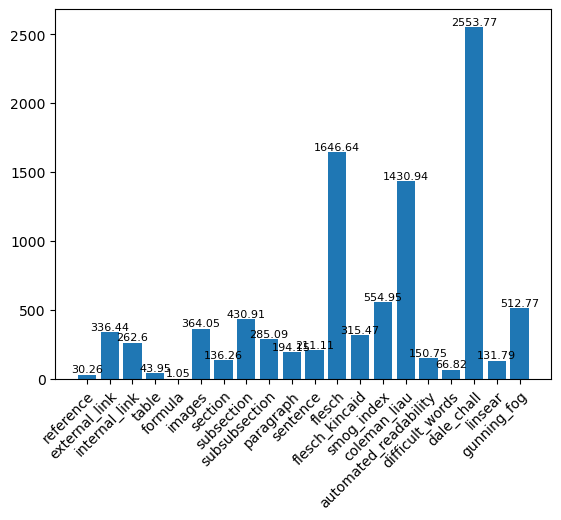

In [11]:
# use ANOVA correlation coefficient to select top 10 features
anova_selector = SelectKBest(score_func=f_classif, k=10)
X_train_anova = anova_selector.fit_transform(X_train[numerical_features], y_train)
X_test_anova = anova_selector.transform(X_test[numerical_features])

ANOVA_features = visualise_SelectKBest_feature(anova_selector, numerical_features)

## Kendall

reference: 0.1596 - significant
external_link: 0.1111 - significant
internal_link: 0.1005 - significant
table: 0.0759 - significant
formula: -0.0076 - not significant
images: 0.0684 - significant
section: 0.0962 - significant
subsection: 0.0178 - significant
subsubsection: -0.0871 - significant
paragraph: 0.0889 - significant
sentence: 0.1322 - significant
flesch: 0.3806 - significant
flesch_kincaid: -0.1978 - significant
smog_index: -0.0191 - significant
coleman_liau: -0.3582 - significant
automated_readability: -0.1356 - significant
difficult_words: 0.1051 - significant
dale_chall: -0.3505 - significant
linsear: 0.1521 - significant
gunning_fog: -0.1930 - significant


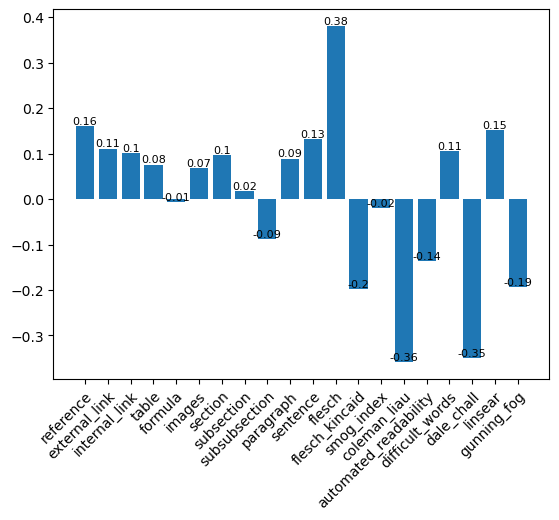

In [12]:
# rank the numerical value in each numerical features
X_train_ranked = np.apply_along_axis(lambda x: np.argsort(np.argsort(x)), 0, X_train[numerical_features])
X_test_ranked = np.apply_along_axis(lambda x: np.argsort(np.argsort(x)), 0, X_test[numerical_features])

# calculate Kendall's correlation coefficient for all numerical features
scores = []
p_values = []
for i in range(len(numerical_features)):
    tau, p = kendalltau(X_train_ranked[:, i], y_train)
    scores.append(tau)
    p_values.append(p)
    
Kendall_features = visualise_Kendall_coefficient(scores, p_values, numerical_features)

## Chi-Squared 

reference: 413.7391 - significant
external_link: 1336.7860 - significant
internal_link: 1527.3841 - significant
table: 17.4813 - significant
formula: 11.5160 - significant
images: 426.8020 - significant
section: 157.6449 - significant
subsection: 1546.6621 - significant
subsubsection: 545.0505 - significant
paragraph: 1133.3829 - significant
sentence: 1263.1284 - significant
flesch: 61.8755 - significant
flesch_kincaid: 352.1377 - significant
smog_index: 103.9309 - significant
coleman_liau: 401.7730 - significant
automated_readability: 334.1319 - significant
difficult_words: 501.0147 - significant
dale_chall: 3952.9792 - significant
linsear: 49.6616 - significant
gunning_fog: 497.1863 - significant


C:\Users\khais\anaconda3\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


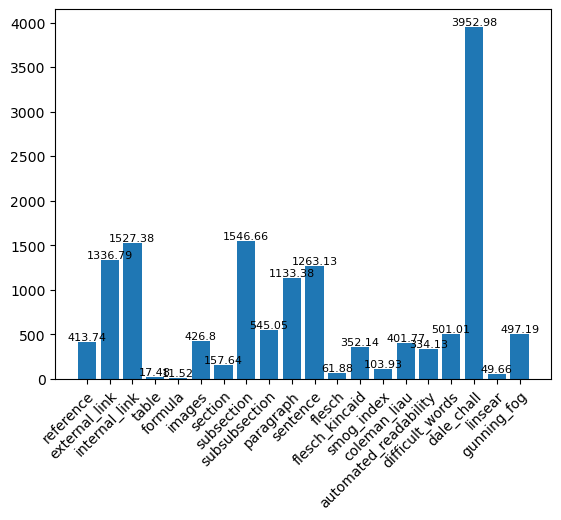

In [13]:
# convert numerical values to categorical based on bins 
discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
X_train_binned = discretizer.fit_transform(X_train[numerical_features])
X_test_binned = discretizer.transform(X_test[numerical_features])

# use Chi-Squared Test to select top 10 features
chi2_selector = SelectKBest(score_func=chi2, k=10)
X_train_chi2 = chi2_selector.fit_transform(X_train_binned, y_train)
X_test_chi2 = chi2_selector.transform(X_test_binned)

Chi_squared_features = visualise_SelectKBest_feature(chi2_selector, numerical_features)

# Top 10 Features Comparison

In [14]:
print("Features From ANOVA")
display(ANOVA_features)

print("Features From Kendall's")
display(Kendall_features)

print("Features From Chi-Squared")
display(Chi_squared_features)

Features From ANOVA


['external_link',
 'images',
 'subsection',
 'subsubsection',
 'flesch',
 'flesch_kincaid',
 'smog_index',
 'coleman_liau',
 'dale_chall',
 'gunning_fog']

Features From Kendall's


['reference',
 'external_link',
 'sentence',
 'flesch',
 'flesch_kincaid',
 'coleman_liau',
 'automated_readability',
 'dale_chall',
 'linsear',
 'gunning_fog']

Features From Chi-Squared


['external_link',
 'internal_link',
 'images',
 'subsection',
 'subsubsection',
 'paragraph',
 'sentence',
 'difficult_words',
 'dale_chall',
 'gunning_fog']